In [15]:
import pandas as pd
import numpy as np
import requests
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
    
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns

In [16]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-03-13 15:33:46.525269: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-03-13 15:33:46.525717: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30047}
2022-03-13 15:33:46.532499: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-03-13 15:33:46.532558: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30047}


In [17]:
data = pd.read_csv('data/dialect_dataset_preprocessed.csv')
countries=np.array(['United Arab Emirates','Bahrain','Algeria','Egypt','Iraq','Jordan','Kuwait','Lebanon','Libya','Morocco','Oman','Palestine','Qatar','Saudi Arabia','Sudan','Syrian','Tunisia','Yemen'])

## read data from API

In [18]:
new_data=data[['text2','dialect']]
new_data.shape

(458197, 2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

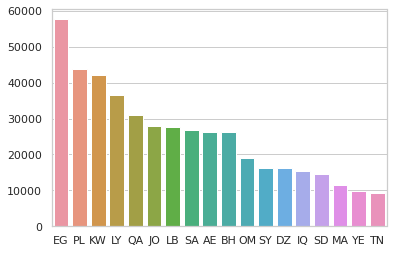

In [19]:
## pie chart of the distribution of the dialects
count_values = new_data['dialect'].value_counts()
sns.set(style="whitegrid")
sns.barplot(count_values.index,count_values.values)

In [20]:
new_data.drop_duplicates(inplace=True)
new_data.dropna(inplace=True)
df=pd.DataFrame(columns=['text2','dialect'])
for i in np.unique(new_data['dialect']):
    temp=new_data.loc[new_data['dialect']==i].iloc[:10000]
    print(temp.shape)
    df=df.append(temp,ignore_index=True)
    
X=df['text2']
Y=df['dialect']
new_data.shape

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(9217, 2)
(9896, 2)


(456831, 2)

### Encode Y

In [21]:
enc=LabelEncoder()
Y=enc.fit_transform(Y)

## Visualization

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

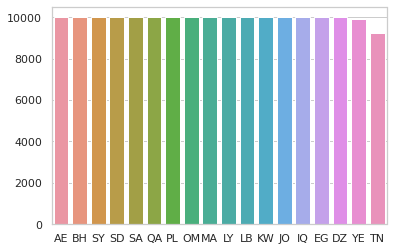

In [22]:
## pie chart of the distribution of the dialects
count_values = df['dialect'].value_counts()
sns.set(style="whitegrid")
sns.barplot(count_values.index,count_values.values)

In [23]:
X_train , X_test ,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,stratify=y_test)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

print("vocab size:",len(tokenizer.word_index))

X_train = pad_sequences(X_train, padding='post', maxlen=20)
X_test = pad_sequences(X_test, padding='post', maxlen=20)
X_val = pad_sequences(X_val, padding='post', maxlen=20)

y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)
y_val=tf.keras.utils.to_categorical(y_val)

vocab size: 202196


In [ ]:
import pickle
with open('backend/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
# with tpu_strategy.scope():

#create LSTM model with keras
embedding_dim = 100
dropout = 0.5
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=1e-2,
#         decay_steps=10000,
#         decay_rate=0.7)
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model = Sequential()
model.add(layers.Embedding(input_dim=202196, 
                            output_dim=100, 
                            input_length=20))

model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.5, return_sequences=True))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation='relu',))

#     model.add(layers.BatchNormalization())

#     model.add(layers.Dense(32, activation='relu'))    

#     model.add(layers.Dense(16, activation='relu'))    

model.add(layers.Dense(len(np.unique(Y)), activation='softmax'))

model.compile(optimizer=opt, 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           20219600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 100)           80400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               12928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 18)               

In [38]:
history = model.fit(X_train, y_train,
            epochs=60,
            verbose=True,
            validation_data=(X_val,y_val),batch_size=128)

Epoch 1/20
1120/1120 [==============================] - 22s 19ms/step - loss: 1.6064 - accuracy: 0.4922 - val_loss: 1.8636 - val_accuracy: 0.4181
Epoch 2/20
1120/1120 [==============================] - 22s 19ms/step - loss: 1.5942 - accuracy: 0.4959 - val_loss: 1.8587 - val_accuracy: 0.4197
Epoch 3/20
1120/1120 [==============================] - 22s 20ms/step - loss: 1.5822 - accuracy: 0.5004 - val_loss: 1.8592 - val_accuracy: 0.4208
Epoch 4/20
1120/1120 [==============================] - 22s 19ms/step - loss: 1.5730 - accuracy: 0.5031 - val_loss: 1.8589 - val_accuracy: 0.4222
Epoch 5/20
1120/1120 [==============================] - 22s 20ms/step - loss: 1.5638 - accuracy: 0.5072 - val_loss: 1.8578 - val_accuracy: 0.4209
Epoch 6/20
1120/1120 [==============================] - 22s 20ms/step - loss: 1.5544 - accuracy: 0.5095 - val_loss: 1.8570 - val_accuracy: 0.4225
Epoch 7/20
1120/1120 [==============================] - 22s 19ms/step - loss: 1.5413 - accuracy: 0.5152 - val_loss: 1.8546 -

In [39]:
y_pred = model.predict(X_test)

print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),target_names=countries))


                      precision    recall  f1-score   support

United Arab Emirates       0.36      0.32      0.34      1000
             Bahrain       0.29      0.30      0.29      1000
             Algeria       0.48      0.49      0.49      1000
               Egypt       0.48      0.70      0.57      1000
                Iraq       0.56      0.56      0.56      1000
              Jordan       0.35      0.29      0.32      1000
              Kuwait       0.38      0.32      0.35      1000
             Lebanon       0.54      0.56      0.55      1000
               Libya       0.59      0.56      0.57      1000
             Morocco       0.65      0.60      0.62      1000
                Oman       0.30      0.36      0.33      1000
           Palestine       0.33      0.34      0.34      1000
               Qatar       0.39      0.40      0.39      1000
        Saudi Arabia       0.30      0.38      0.33      1000
               Sudan       0.66      0.62      0.64      1000
       

In [40]:
def predict(model,text):
    text =pd.Series(text)
    text1=tokenizer.texts_to_sequences(text)
    text1=pad_sequences(text1, padding='post', maxlen=20)
    p=model.predict(text1)
    res=countries[np.argmax(p,axis=1)]
#     print(countries[np.argmax(p,axis=1)])
    for i in range(len(text)):
        print(text[i],end='\n')
        print(res[i])
        print('=====================')

In [41]:
tx=['آني ما أحب المدارس تصرف هوايا ملابس، وإحنا ناس هوايا فقره عدنا زنكين العشيرة يبيع بالشارع محابس','انت عايز ايه مني دلوقتي','اللي هسي تبلكا قبلي اخش اشربكه','الهربات كثير والودافة واحدة','حط فلوسك بالشمس وإقعد بالظلال .','ايش بدك انا ما بروح هونيك','إللّي ما شافش المرمة ما يعرفش اش فما.']
predict(model,tx)

آني ما أحب المدارس تصرف هوايا ملابس، وإحنا ناس هوايا فقره عدنا زنكين العشيرة يبيع بالشارع محابس
Iraq
انت عايز ايه مني دلوقتي
Egypt
اللي هسي تبلكا قبلي اخش اشربكه
Sudan
الهربات كثير والودافة واحدة
Jordan
حط فلوسك بالشمس وإقعد بالظلال .
Saudi Arabia
ايش بدك انا ما بروح هونيك
Lebanon
إللّي ما شافش المرمة ما يعرفش اش فما.
Tunisia


In [ ]:
model.save('backend/Lstm_model.hdf5')